### Case Study 1

[Kaggle - dataset description](https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, roc_auc_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
import time
from imblearn.over_sampling import SMOTENC
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

In [2]:
#Funkcja do wizualizacji macierzy pomyłek i oceny modelu
def cm_results(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_names = ['not fraud', 'fraud']
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.show()

    class_rep=classification_report(y_test, y_pred)
    print(class_rep)

In [4]:
dane=pd.read_csv("../datasets/case1.csv", delimiter=";")
dane=dane.drop(columns=["Unnamed: 0", "Index", "Address"])
y_data=dane[["FLAG"]]
X_data=dane.drop(columns="FLAG")

In [5]:
X_data

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,45.806785,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,2.613269,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,1.165453,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,500.000000,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,12.802411,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,12635.10,631.39,58748.48,4,13,0,11,4,0.004082,12.000000,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,2.0,,GSENetwork
9837,0.00,0.00,0.00,0,0,0,0,0,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
9838,2499.44,2189.29,261601.88,67,43,0,31,44,0.001078,21.310000,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,5.0,,Free BOB Tokens - BobsRepair.com
9839,0.00,0.00,0.00,0,1,0,1,0,0.500000,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
y_data.value_counts()/y_data.value_counts().sum()

FLAG
0       0.778579
1       0.221421
Name: count, dtype: float64

### Przygotowanie danych

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [34]:
#Zamiana słów na typ kategoryczny (potrzebne do xgboost)
X_train['ERC20 most sent token type'] = X_train['ERC20 most sent token type'].astype("category")
X_train['ERC20_most_rec_token_type'] = X_train['ERC20_most_rec_token_type'].astype("category")

X_test['ERC20 most sent token type'] = X_test['ERC20 most sent token type'].astype("category")
X_test['ERC20_most_rec_token_type'] = X_test['ERC20_most_rec_token_type'].astype("category")

In [7]:
#oddzielenie danych numerycznych od tekstowych
X_train_num=X_train.iloc[:,:-2]
X_train_text=X_train.iloc[:, -2:]

X_test_num=X_test.iloc[:,:-2]
X_test_text=X_test.iloc[:, -2:]

#### Text processing

In [8]:
#Zamiana brakujących wartości na "None"
X_train_text.replace(["0", "", " ", np.nan], None, inplace=True)
X_test_text.replace(["0", "", " ", np.nan], None, inplace=True)

C:\Users\dorot\AppData\Local\Temp\ipykernel_10400\3996420132.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X_train_text.replace(["0", "", " ", np.nan], None, inplace=True)


In [9]:
#Braki w kolumnie 'ERC20_most_rec_token_type'
X_train_text.iloc[:, -1].isna().sum()/X_train_text.shape[0]

0.5356961382113821

In [10]:
# Braki w kolumnie 'ERC20 most sent token type'
X_train_text.iloc[:, -2].isna().sum()/X_train_text.shape[0]

0.8407012195121951

#### Numeric data processing

In [11]:
#Uzupełnienie brakujących wartości za pomocą metody K najblższych sąsiadów
imputer = KNNImputer(n_neighbors=3)
X_train_num_imp = imputer.fit_transform(X_train_num)
X_test_num_imp = imputer.transform(X_test_num)

In [12]:
#Standaryzacja uzupełnionych danych
X_cols=X_train_num.columns

scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(X_train_num_imp)
scaled_train_df = pd.DataFrame(scaled_train_data, columns=X_cols)

scaled_test_data = scaler.transform(X_test_num_imp)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=X_cols)

In [13]:
#Boxploty dla wszystkich zmiennych
scaled_train_df2=pd.concat([y_data, scaled_train_df], axis=1)
fig = px.box(scaled_train_df2, color="FLAG")
fig.update_layout(xaxis_title="Nr zmiennej",
                  yaxis_title="Wartość zestandaryzowana")
fig.write_html("boxplot_alldata.html")

Na podstawie boxplotów, możemy zauważyć, że jest bardzo dużo wartości odstających. Zdecydowano jednak, aby ich nie usuwać, ponieważ znacznie zmniejszyłoby to zbiór danych. Ponadto, skoro charakterystyka zmiennych treningowych pokazuje, że mają one tak dużą zmienność, to dane testowe najprawdopodobniej też będą się tym charakteryzować.

In [14]:
#Złączenie danych zestandaryzowanych z danymi tekstowymi
combined_X_train_data = pd.concat([scaled_train_df, X_train_text.reset_index(drop=True)], axis=1)
combined_X_test_data = pd.concat([scaled_test_df, X_test_text.reset_index(drop=True)], axis=1)

In [37]:
y_train=y_train.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)
X_train=X_train.reset_index(drop=True)

### XGBoost dla wszystkich kolumn

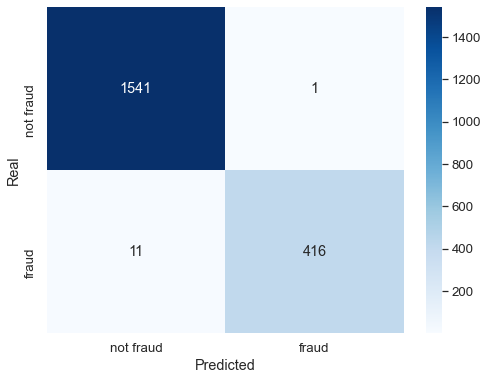

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1542
           1       1.00      0.97      0.99       427

    accuracy                           0.99      1969
   macro avg       1.00      0.99      0.99      1969
weighted avg       0.99      0.99      0.99      1969



In [35]:
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm_results(y_test, y_pred)

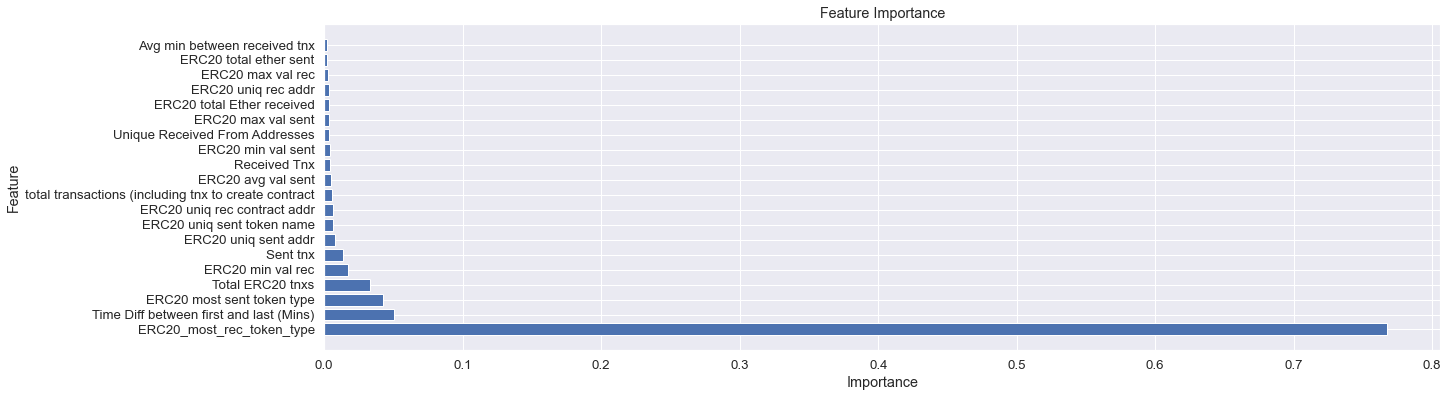

In [36]:
model=clf
importance = model.feature_importances_

feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

Najbardziej istotną zmienną jest 'ERC20_most_rec_token_type', mimo że ma ona dużo brakujących wartości. Poniżej sprawdzono, jaki jest stosunek wystąpień poszczególnych słów w tej kolumnie, w zależności od klasy.

In [38]:
data_0 = X_train[y_train['FLAG']==0]['ERC20_most_rec_token_type']
data_1 = X_train[y_train['FLAG']==1]['ERC20_most_rec_token_type']

In [39]:
word_freq_0 = data_0.str.split(expand=True).stack().value_counts()/data_0.shape[0]
word_freq_1 = data_1.str.split(expand=True).stack().value_counts()/data_1.shape[0]

word_freq_df = pd.DataFrame({'not_fraud': word_freq_0, 'fraud': word_freq_1}).fillna(0)

word_freq_df = word_freq_df.sort_values(by='not_fraud', ascending=False)

top_20_words = word_freq_df.head(20)
data=top_20_words.reset_index()

In [40]:
transformed_df = pd.melt(data, id_vars=['index'], var_name='is_fraud', value_name='value')
transformed_df['is_fraud'] = transformed_df['is_fraud'].map({'not_fraud': 0, 'fraud': 1})

<AxesSubplot:xlabel='value', ylabel='index'>

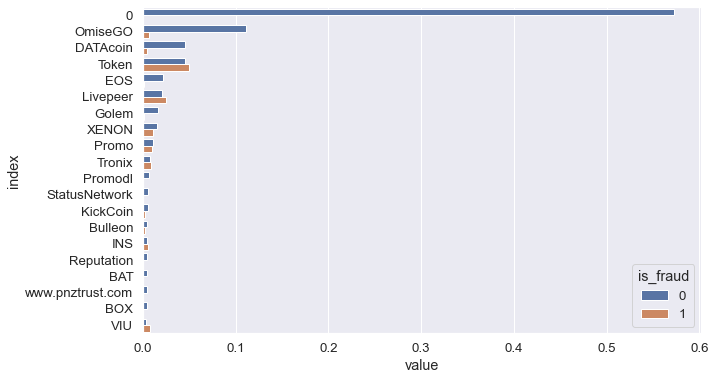

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(data=transformed_df, y='index', x='value', hue='is_fraud', orient='h') 

Pierwsza zmienna "0" odpowiada wszystkim wierszom, w których nie było podanej wartości dla cechy: 'ERC20_most_rec_token_type'. Okazuje się, że za każdym razem, gdy zmienna 'ERC20_most_rec_token_type' nie była podana, to występował brak przestępstwa. Może to oznaczać, że zawsze, gdy występowało przestępstwo, to podawano nazwę tokenu.

In [43]:
data_0 = X_train[y_train['FLAG']==0]['ERC20 most sent token type']
data_1 = X_train[y_train['FLAG']==1]['ERC20 most sent token type']

In [44]:
word_freq_0 = data_0.str.split(expand=True).stack().value_counts()/data_0.shape[0]
word_freq_1 = data_1.str.split(expand=True).stack().value_counts()/data_1.shape[0]

word_freq_df = pd.DataFrame({'not_fraud': word_freq_0, 'fraud': word_freq_1}).fillna(0)

word_freq_df = word_freq_df.sort_values(by='not_fraud', ascending=False)

top_20_words = word_freq_df.head(20)
data=top_20_words.reset_index()

In [45]:
transformed_df = pd.melt(data, id_vars=['index'], var_name='is_fraud', value_name='value')
transformed_df['is_fraud'] = transformed_df['is_fraud'].map({'not_fraud': 0, 'fraud': 1})

Text(0.5, 1.0, 'ERC20 most sent token type')

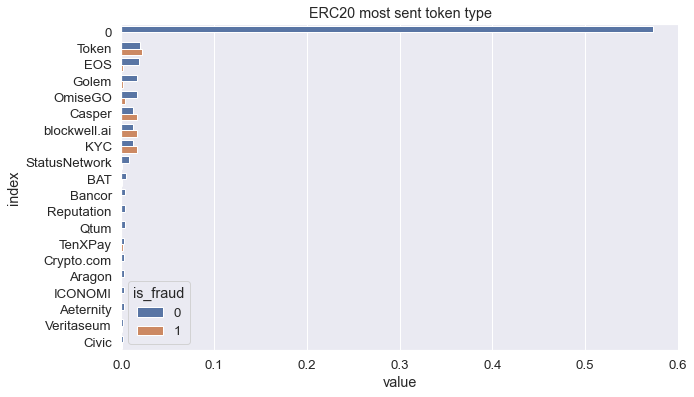

In [49]:
plt.figure(figsize=(10, 6))
sns.barplot(data=transformed_df, y='index', x='value', hue='is_fraud', orient='h') 
plt.title('ERC20 most sent token type')

Również w przypadku zmiennej: 'ERC20 most sent token type', braki występują tylko w przypadku braku oszustwa.

### Klasyfikacja na podstawie wszystkich kolumn numerycznych bez resamplingu

In [25]:
A=3
B=1
weights={ 0: B, 1: A}

models = {
    'RandomForest': RandomForestClassifier(n_estimators= 100, min_samples_split= 5, min_samples_leaf= 1),
    'XGBoost': xgb.XGBClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'LogisticRegression': LogisticRegression(),
    'LogisticRegression_weigths': LogisticRegression(solver='lbfgs', class_weight=weights),
    'SVM': SVC()
}

results = pd.DataFrame(columns=['Model', 'ROC-AUC', 'Czas wykonywania'])

for model_name, model in models.items():

        start=time.time()
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(model, scaled_train_df,  y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
        czas=time.time()-start

        result_row ={
            'Model': model_name,
            'ROC-AUC': np.mean(scores),
            'Czas wykonywania': czas
        }

        results=pd.concat([results, pd.DataFrame([result_row])], ignore_index=True)

C:\Users\dorot\AppData\Local\Temp\ipykernel_10400\887519178.py:29: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [26]:
results

,Model,ROC-AUC,Czas wykonywania
0,RandomForest,0.990346,7.504696
1,XGBoost,0.994728,2.207051
2,KNN,0.949778,0.515731
3,LogisticRegression,0.849501,0.696954
4,LogisticRegression_weigths,0.849178,0.665128
5,SVM,0.909402,13.007716


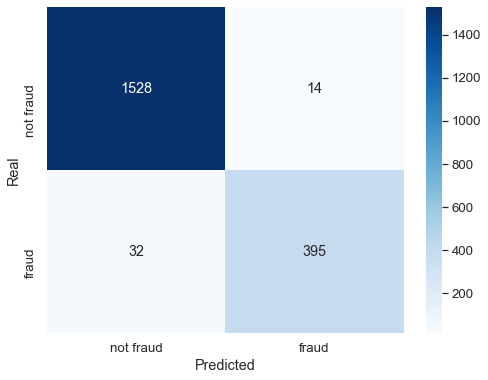

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1542
           1       0.97      0.93      0.94       427

    accuracy                           0.98      1969
   macro avg       0.97      0.96      0.97      1969
weighted avg       0.98      0.98      0.98      1969



In [27]:
model_xgb=xgb.XGBClassifier()
model_xgb.fit(scaled_train_df,  y_train)
y_pred=model_xgb.predict(scaled_test_df)

cm_results(y_test, y_pred)

Klasyfikacja pozbawiona zmiennych tekstowych jest tochę mniej skuteczna, niż gdy dane tekstowe są brane pod uwagę.

### Klasyfikacja na podstawie zmiennych z PCA bez resamplingu

In [53]:
pca = PCA(n_components=0.98)
X_train_pca = pca.fit_transform(scaled_train_df)
X_test_pca = pca.transform(scaled_test_df)

print("Liczba:", pca.n_components_)
print("Procent wariancji:", np.sum(pca.explained_variance_ratio_))

Liczba: 24
Procent wariancji: 0.980171434079364


Możemy zmniejszyć liczbę zmiennych z 45 do 24 zachowując przy tym 98% wariancji.

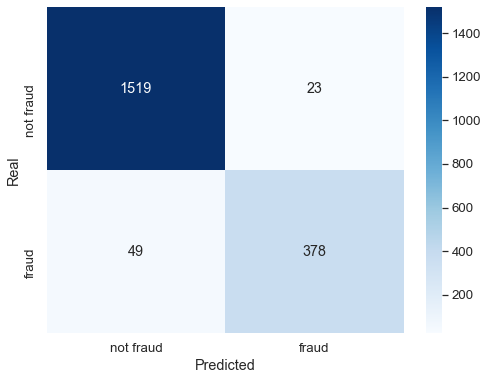

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1542
           1       0.94      0.89      0.91       427

    accuracy                           0.96      1969
   macro avg       0.96      0.94      0.94      1969
weighted avg       0.96      0.96      0.96      1969



In [54]:
model_xgb = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)
model_xgb.fit(X_train_pca,  y_train)
y_pred=model_xgb.predict(X_test_pca)
cm_results(y_test, y_pred)

Ze względu na częściową utatę danych, to liczba FP i FN trochę się pogorszyła.

### Klasyfikacja na podstawie kolumn numerycznych z resamplingiem

#### Resampling

In [30]:
y_train.value_counts()

FLAG
0       6120
1       1752
Name: count, dtype: int64

In [31]:
#Dodatkowe wiersze na podstawie pełnych wierszy
smote = SMOTE(random_state=42, sampling_strategy=0.3)
X_smote, y_smote = smote.fit_resample(scaled_train_df, y_train)
y_smote.value_counts()

FLAG
0       6120
1       1836
Name: count, dtype: int64

In [32]:
#UnderSampling
rus=RandomUnderSampler(sampling_strategy=0.5)
X_resampled, y_resampled =rus.fit_resample(X_smote, y_smote)
print(y_resampled .value_counts())

FLAG
0       3672
1       1836
Name: count, dtype: int64


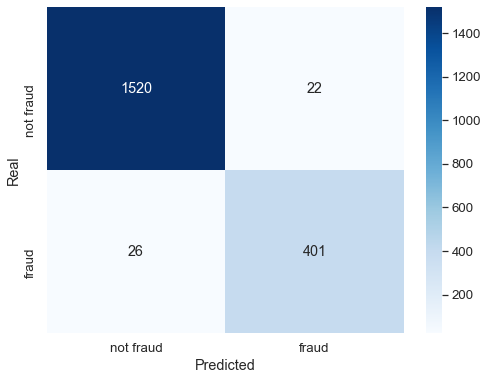

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1542
           1       0.95      0.94      0.94       427

    accuracy                           0.98      1969
   macro avg       0.97      0.96      0.96      1969
weighted avg       0.98      0.98      0.98      1969



In [33]:
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)
clf.fit(X_resampled, y_resampled)
y_pred = clf.predict(scaled_test_df)
cm_results(y_test, y_pred)

Resampling dla danych numerycznych pozwolił zmniejszyć liczbę FN, ale macierz pomyłek jest gorsza niż w przypadku modelu XGBoost wytrenowanemu na całych danych. Jednak z uwagi na bardzo duże braki w danych tekstowych, wybrano model opierający się jedynie na danych numerycznych. W ten sposób unikamy sytuacji, w której brak danych tekstowych zwiększa prawdopodobieństwo, że przestępstwo nie wystąpiło.